## INTRODUCTION
# Connexion avec elasticsearch
dans cette partie je vais essayer d'utliser la biblitheque de elasticsearch pour me connecter et extraire les logs 




- debut du code 

In [57]:
from elasticsearch import Elasticsearch
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # Ajout pour le formatage de l'axe x
import numpy as np

# Connexion à Elasticsearch
es = Elasticsearch([{'scheme': 'http', 'host': 'localhost', 'port': 9200}])

# Vérifier la connexion
if es.ping():
    print("Connecté à Elasticsearch")
else:
    print("Échec de la connexion")
    exit()


Connecté à Elasticsearch


- Requête pour récupérer les logs | Extraction des résultats | Filtrer les logs pour vérifier la présence des informations nécessaires



In [58]:


query = {
    "query": {"match_all": {}},
    "_source": ["userID", "level", "timestamp", "logger"],
    "size": 1000
}
 
results = es.search(body=query)
logs = []

for hit in results['hits']['hits']:
    log = hit['_source']
    if all(key in log for key in ['userID', 'level', 'timestamp']):
        logs.append(log)

print(f"Logs filtrés: {len(logs)} logs")



Logs filtrés: 638 logs


- Conversion des timestamps et extraction des données utiles

In [59]:


data = []
for log in logs:
    timestamp = log['timestamp']
    try:
        timestamp_dt = datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S.%f")
        data.append([log['userID'], log['level'], timestamp_dt])
    except ValueError:
        continue

print(data)


[['22945', 'INFO', datetime.datetime(2024, 12, 9, 11, 42, 44, 73000)], ['81692', 'INFO', datetime.datetime(2024, 12, 9, 15, 17, 59, 594000)], ['46202', 'INFO', datetime.datetime(2024, 12, 9, 15, 32, 13, 118000)], ['18410', 'INFO', datetime.datetime(2024, 12, 9, 11, 51, 33, 149000)], ['3643', 'INFO', datetime.datetime(2024, 12, 9, 10, 23, 13, 539000)], ['18410', 'INFO', datetime.datetime(2024, 12, 9, 15, 10, 31, 465000)], ['18410', 'INFO', datetime.datetime(2024, 12, 9, 9, 51, 53, 271000)], ['23579', 'INFO', datetime.datetime(2024, 12, 9, 16, 16, 58, 995000)], ['18410', 'INFO', datetime.datetime(2024, 12, 9, 11, 4, 33, 177000)], ['46202', 'INFO', datetime.datetime(2024, 12, 9, 15, 29, 4, 139000)], ['18410', 'INFO', datetime.datetime(2024, 12, 9, 14, 16, 6, 695000)], ['21763', 'INFO', datetime.datetime(2024, 12, 9, 12, 1, 40, 237000)], ['3643', 'INFO', datetime.datetime(2024, 12, 9, 16, 58, 13, 360000)], ['53318', 'INFO', datetime.datetime(2024, 12, 9, 19, 53, 50, 338000)], ['75689', 'IN

- je Regroupe par utilisateur, heure et niveau de log


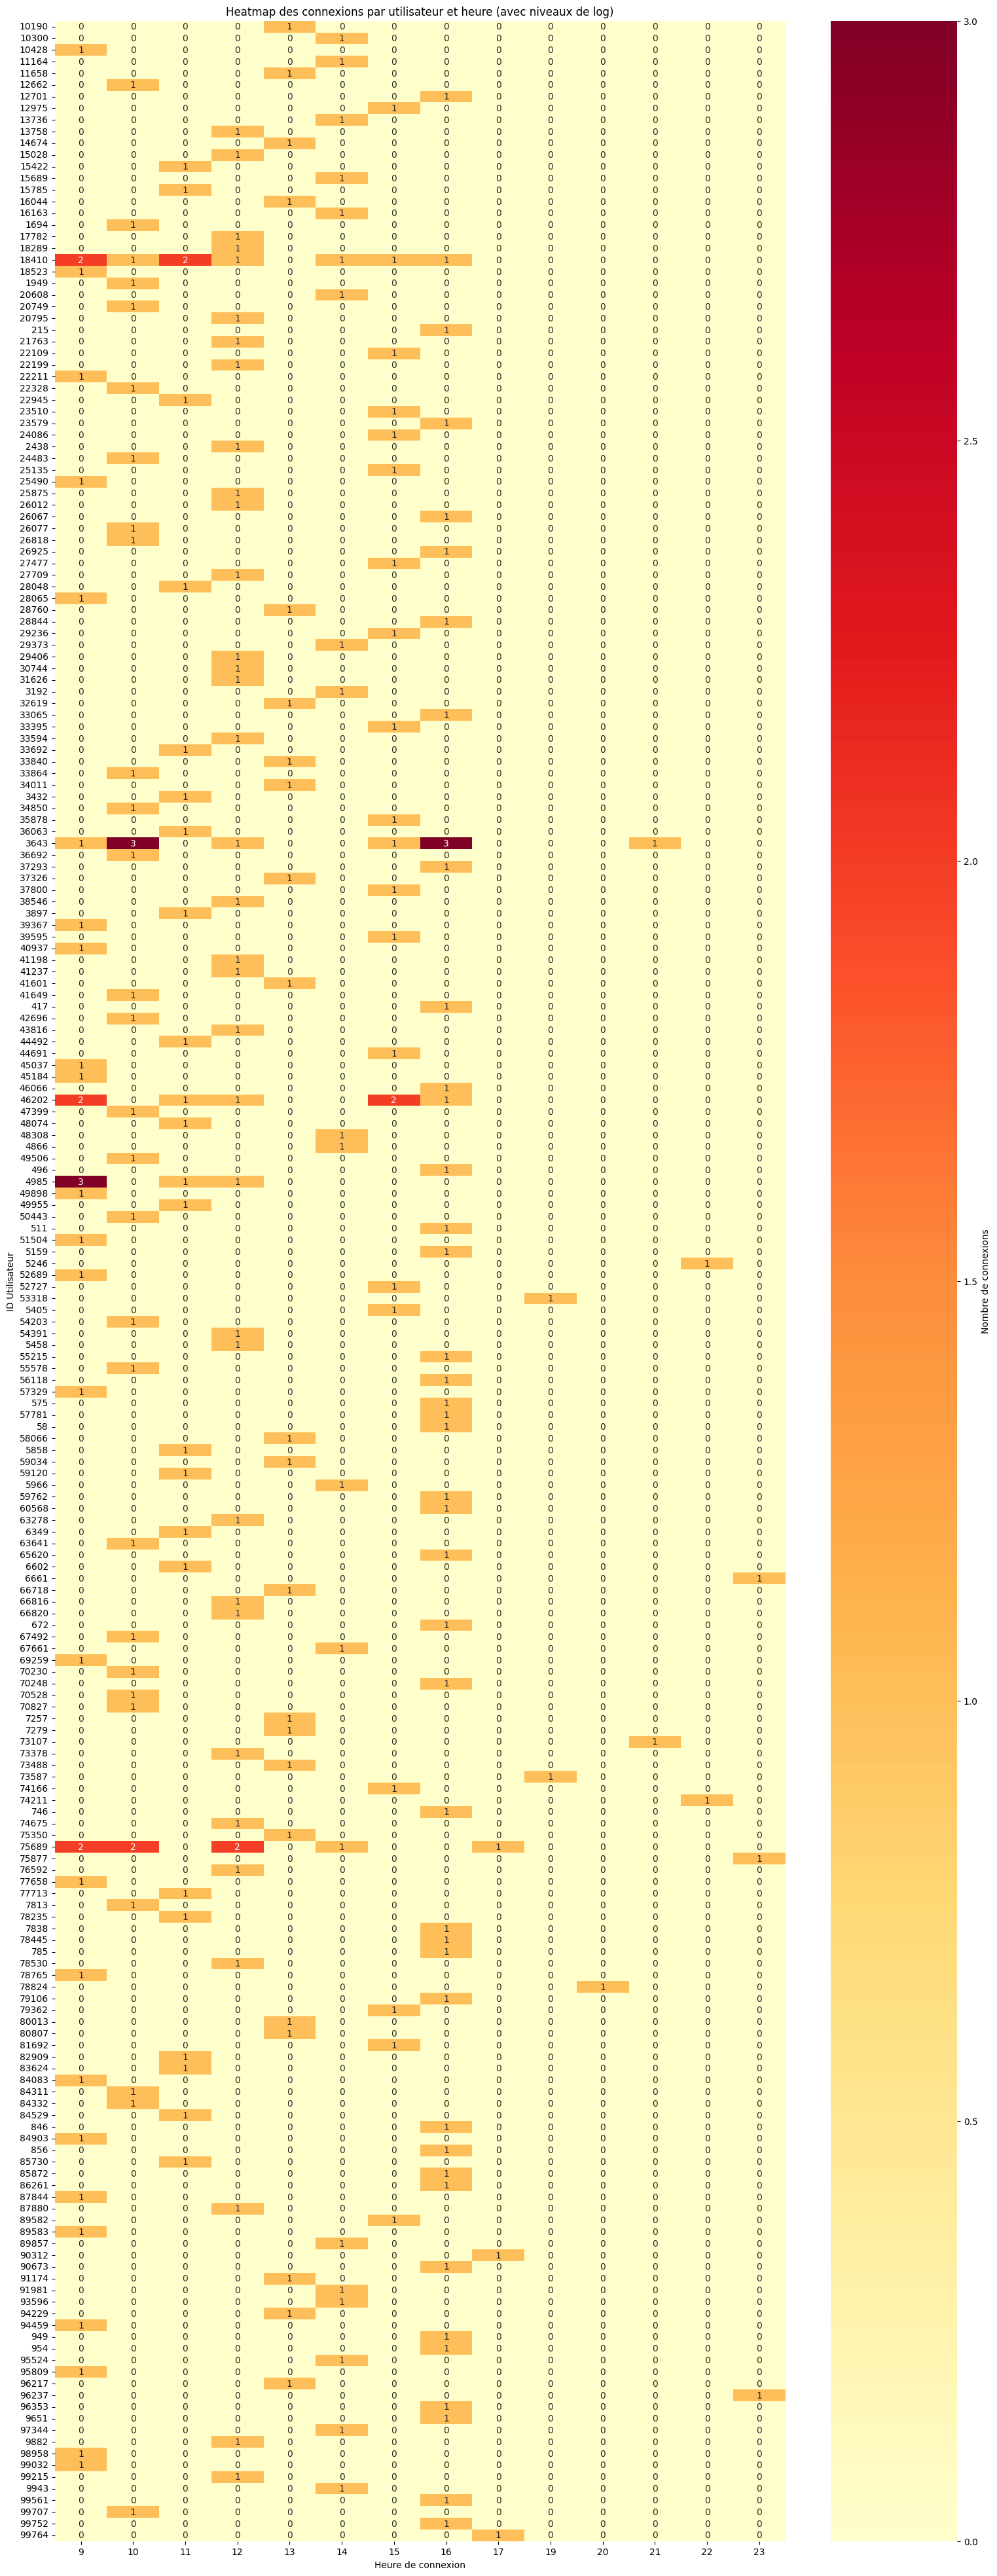

In [60]:
import seaborn as sns

df = pd.DataFrame(data[:250], columns=["userID", "level", "timestamp"])
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour

agg_df = df.groupby(['userID', 'hour', 'level']).size().reset_index(name='count')

# Pivot pour la heatmap avec le niveau de log
pivot_table = agg_df.pivot_table(index='userID', columns='hour', values='count', aggfunc='sum', fill_value=0)

# Plot de la heatmap
plt.figure(figsize=(18, 50))
sns.heatmap(pivot_table, cmap="YlOrRd", annot=True, fmt=".0f", cbar_kws={'label': 'Nombre de connexions'})

# Configuration du graphique
plt.title("Heatmap des connexions par utilisateur et heure (avec niveaux de log)")
plt.xlabel("Heure de connexion")
plt.ylabel("ID Utilisateur")
plt.yticks(rotation=360)

# plt.xticks(rotation=45)
plt.show()

In [61]:
df = pd.DataFrame(data, columns=["userID", "level", "timestamp"])
df['timestamp'] = pd.to_datetime(df['timestamp']) 
df['hour'] = df['timestamp'].dt.hour 

# Compter les connexions par utilisateur
user_connections = df['userID'].value_counts().reset_index()
user_connections.columns = ['userID', 'connection_count']

# Encoder les données pour IsolationForest
encoder_level = LabelEncoder()
df['level_encoded'] = encoder_level.fit_transform(df['level'])

iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
df['anomaly'] = iso_forest.fit_predict(df[['hour', 'level_encoded']])

# Ajouter le nombre de connexions
df = df.merge(user_connections, on='userID')

df_anomalies = df[df['anomaly'] == -1]
df_normal = df[df['anomaly'] == 1]



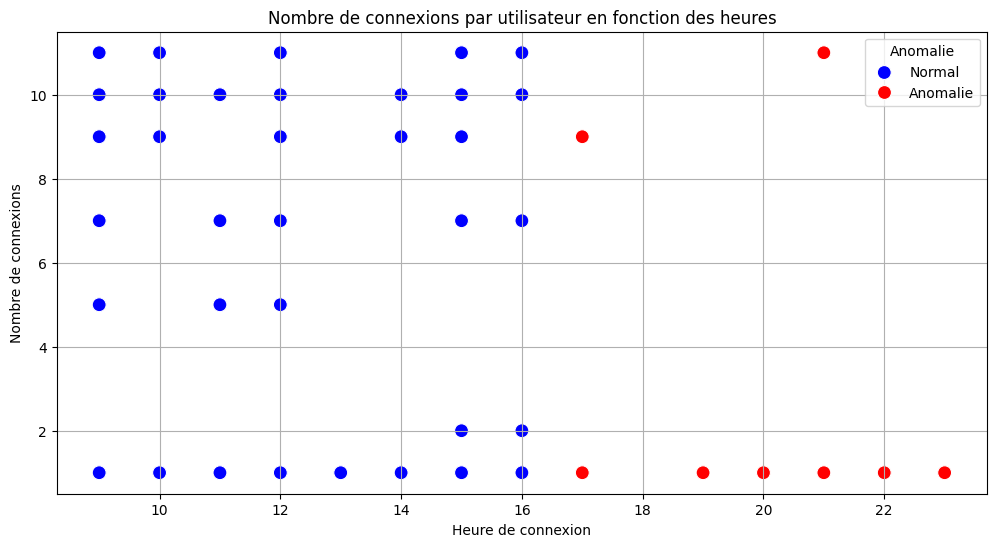

In [62]:

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='hour', y='connection_count', hue='anomaly', palette={1: "blue", -1: "red"}, s=100)
plt.title("Nombre de connexions par utilisateur en fonction des heures")
plt.xlabel("Heure de connexion")
plt.ylabel("Nombre de connexions")
plt.legend(title="Anomalie", labels=["Normal", "Anomalie"])
plt.grid()
plt.show()



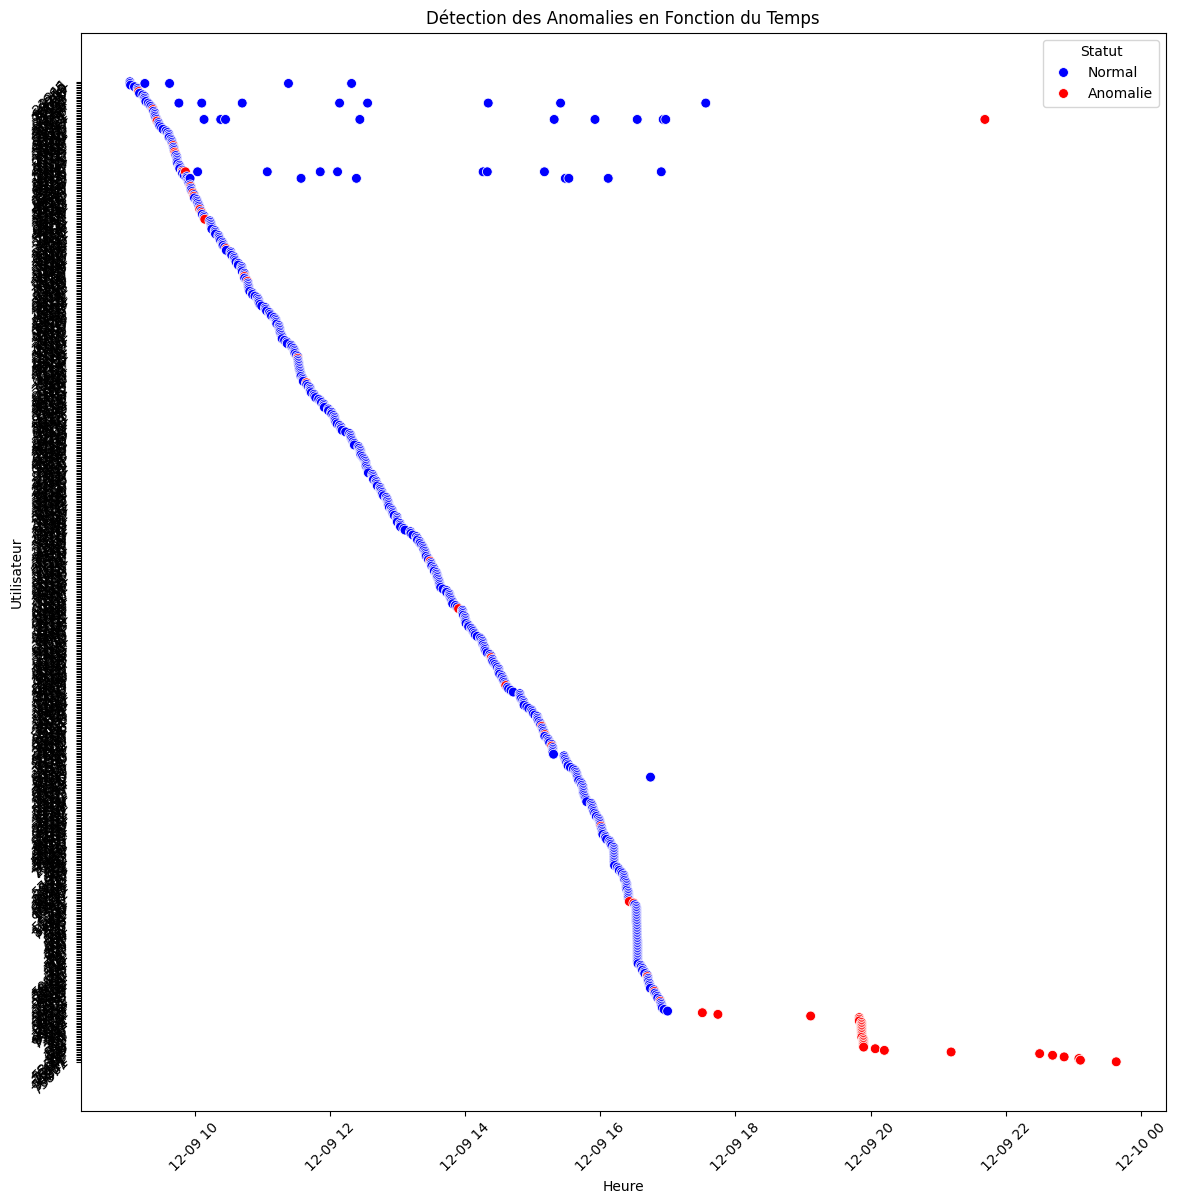

In [63]:
df['timestamp_dt'] = pd.to_datetime(df['timestamp'], errors='coerce')

df = df.sort_values(by='timestamp_dt')

df['hour'] = df['timestamp_dt'].dt.hour

encoder_userID = LabelEncoder()
encoder_level = LabelEncoder()

df['userID_encoded'] = encoder_userID.fit_transform(df['userID'])
df['level_encoded'] = encoder_level.fit_transform(df['level'])

features = df[['userID_encoded', 'level_encoded', 'hour']]

iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
df['anomaly'] = iso_forest.fit_predict(features)
df['anomaly'] = df['anomaly'].map({1: 'Normal', -1: 'Anomalie'})

# Visualisation des résultats

# Graphique 1 : Anomalies en fonction du temps
plt.figure(figsize=(14, 14))
sns.scatterplot(
    x=df['timestamp_dt'], y=df['userID'],
    hue=df['anomaly'], palette={'Normal': 'blue', 'Anomalie': 'red'}, s=50
)
plt.title('Détection des Anomalies en Fonction du Temps')
plt.xlabel('Heure')
plt.ylabel('Utilisateur')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.legend(title="Statut")
plt.show()


